# Code source:
## https://www.kaggle.com/longyin2/titanic-machine-learning-from-disaster-0-842/notebook

# 0. Import Packages

In [110]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
from ggplot import *

In [112]:
from sklearn import preprocessing
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import cross_validation

%matplotlib inline
warnings.filterwarnings('ignore')

# 1. Load Data

In [113]:
train = pd.read_csv("./input/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
test = pd.read_csv("./input/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2. Feature Engineering

In [115]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [116]:
def Name_Title_Code(x):
    if x == 'Mr.':
        return 1
    
    if (x == 'Mrs.' or (x == 'Ms.') or (x == 'Lady.') or (x == 'Mlle.') or (x == 'Mme')):
        return 2
    
    if x == 'Miss':
        return 3
    
    if x == 'Rev.':
        return 4
    
    return 5

train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
test['Name_Title'] = test['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])

In [117]:
def Age_Feature(train, test):
    age_data = train.groupby(['Name_Title', 'Pclass'])['Age']
    
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        i['Age'] = age_data.transform(lambda x: x.fillna(x.mean()))
        
    return train, test

In [118]:
def Family_Feature(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp'] + i['Parch']) == 0, 'Solo',
                                    np.where((i['SibSp'] + i['Parch']) <= 3, 'Nuclear',
                                                 'Big'))
        del i['SibSp']
        del i['Parch']
        
    return train, test

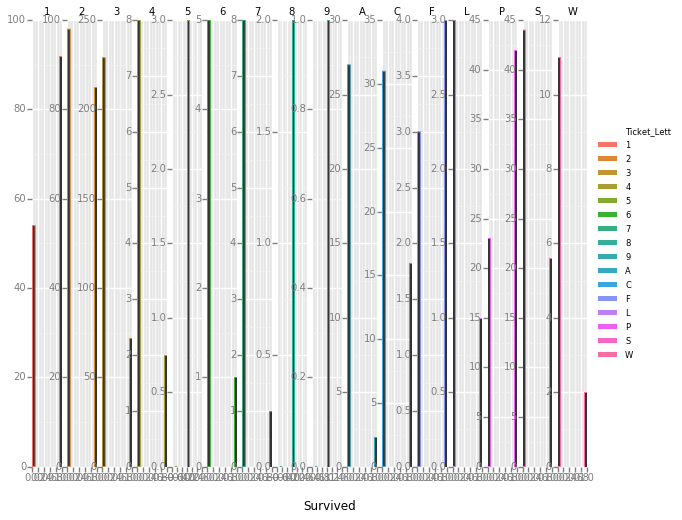

<ggplot: (-9223371910198475127)>


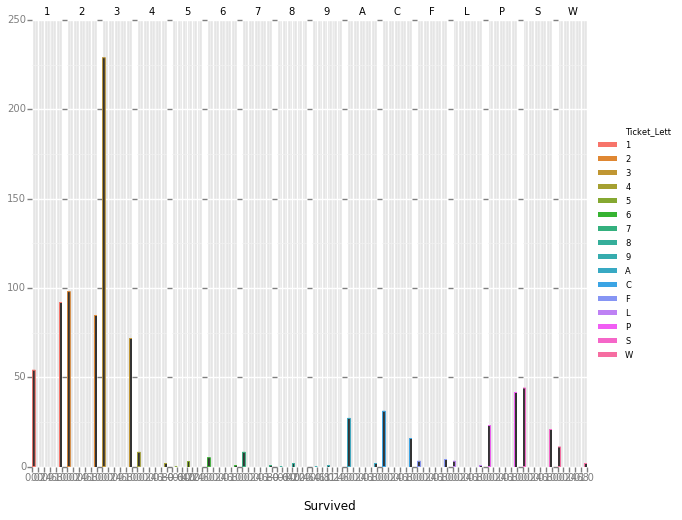

<ggplot: (126651983729)>


In [120]:
def Plot_Ticket(train):
    train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])
    train['Ticket_Lett'] = train['Ticket_Lett'].apply(lambda x: str(x))
    train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
        
    Ticket_Lett_Plot = ggplot(aesthetics = aes(x = 'Survived', color = 'Ticket_Lett'), data = train) + geom_histogram() + facet_grid(y = 'Ticket_Lett', scales = 'free')
    print(Ticket_Lett_Plot)
    Ticket_Lett_Plot2 = ggplot(aesthetics = aes(x = 'Survived', color = 'Ticket_Lett'), data = train) + geom_histogram() + facet_grid(y = 'Ticket_Lett', scales = 'free_x')
    print(Ticket_Lett_Plot2)
    
Plot_Ticket(train)


In [121]:
# It seems that Tickets can be grouped as:
# 1) Biggest: 1, 2, 3
# 2) Second-biggest: A, C, P, S
# 3) Third: 4, 7, W
# 4) Smallest: 5, 6, 8, 9, F, L
def Ticket_Grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
#        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'A', 'C', 'P', 'S']), i['Ticket_Lett'],
#                                    np.where((i['Ticket_Lett']).isin(['4', '7', 'W']),
#                                        'Mid_ticket', np.where((i['Ticket_Lett']).isin(['5', '6', '8', '9', 'F', 'L']),
#                                            'Low_ticket', 'Other_ticket')))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                    np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        
        del i['Ticket']
        
    return train, test

In [122]:
def Cabin_Feature(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        
        del i['Cabin']
        
    return train, test

In [123]:
def Cabin_Num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'], 3)
        
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    
    del train['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num']
    del test['Cabin_num1']
    
    return train, test

In [124]:
def Embarked_Impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
        
    return train, test

In [125]:
def Dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        
        # One-Hot encoding for all the values of the intersect of train and test
        good_cols = [ '{0}_{1}'.format(column, i) for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        
        del train[column]
        del test[column]
        
    return train, test

In [126]:
def Drop(train, test, by = ['PassengerId']):
    for i in [train, test]:
        for z in by:
            del i[z]
    
    return train, test

In [127]:
train, test = Age_Feature(train, test)

In [128]:
train['Name_Title'] = train['Name_Title'].apply(Name_Title_Code)
test['Name_Title'] = test['Name_Title'].apply(Name_Title_Code)

In [129]:
train = pd.get_dummies(columns = ['Name_Title'], data = train)
test = pd.get_dummies(columns = ['Name_Title'], data = test)

In [130]:
train, test = Cabin_Num(train, test)
train, test = Cabin_Feature(train, test)
train, test = Embarked_Impute(train, test)
train, test = Family_Feature(train, test)

In [131]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [132]:
train, test = Ticket_Grouped(train, test)

In [133]:
train, test = Dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Fam_Size','Cabin_Letter'])

In [134]:
train, test = Drop(train, test)

In [135]:
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

# 3. Model Training

In [136]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
                               criterion = 'gini',
                               n_estimators = 700,
                               min_samples_split = 16,
                               min_samples_leaf = 1,
                               max_features = 'auto',
                               oob_score = True,
                               random_state = 1,
                               n_jobs = -1
                           )

rf.fit(train.iloc[:, 1:], train.iloc[:, 0])

print("%.4f" % rf.oob_score_)

0.8361


In [137]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']),
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])),
          axis = 1).sort_values(by = 'importance', ascending = False)[:20]

,variable,importance
14,Sex_1,0.138837
4,Name_Title_1,0.121283
15,Sex_0,0.120332
1,Fare,0.092095
0,Age,0.080082
11,Pclass_3,0.052162
7,Name_Title_5,0.051773
5,Name_Title_2,0.040360
31,Cabin_Letter_n,0.029681
30,Fam_Size_Big,0.029435


# 4. Submit

In [138]:
submit = pd.read_csv('./input/gender_submission.csv')
submit.set_index('PassengerId', inplace = True)

In [139]:
rf_res = rf.predict(test)

In [140]:
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].apply(int)
submit.to_csv('submit.csv')

In [141]:
submit

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,1
900,1
